# Image Dimensions always are (608, 608, 3)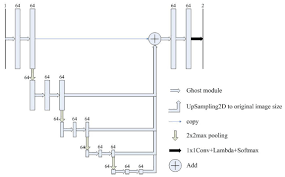

#Half Unet

In [1]:
import tensorflow as tf,os,random,matplotlib.pyplot as plt,cv2,numpy as np,scipy.misc,numpy.random as rng,glob,math,keras,nibabel as nib
from tqdm import tqdm #reading nifti images
from skimage.io import imread, imshow
from skimage.transform import resize
from keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from PIL import Image, ImageDraw, ImageFont
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline
#from read_data import load_images
from keras.layers import concatenate
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model



#Extracting Zip files

In [2]:
import zipfile,os
def extract_zip(zip_file, extract_to):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

In [7]:
# Example usage:
zip_file_path = "/content/Processed_images.zip"
extract_to_directory = "/content/I"

# Ensure the extraction directory exists, if not create it
if not os.path.exists(extract_to_directory):
    os.makedirs(extract_to_directory)


extract_zip(zip_file_path, extract_to_directory)

In [8]:
os.listdir("/content/I")

['23.tif',
 '12.tif',
 '18.tif',
 '17.tif',
 '01.tif',
 '40.tif',
 '35.tif',
 '16.tif',
 '13.tif',
 '04.tif',
 '36.tif',
 '38.tif',
 '27.tif',
 '20.tif',
 '06.tif',
 '31.tif',
 '29.tif',
 '34.tif',
 '03.tif',
 '21.tif',
 '19.tif',
 '32.tif',
 '33.tif',
 '05.tif',
 '30.tif',
 '14.tif',
 '24.tif',
 '09.tif',
 '22.tif',
 '39.tif',
 '11.tif',
 '02.tif',
 '26.tif',
 '28.tif',
 '15.tif',
 '07.tif',
 '25.tif',
 '08.tif',
 '37.tif',
 '10.tif']

#Data Preprocessing

In [ ]:
# @title
from PIL import Image
import os

def pad_and_resize_image(input_path, output_path):
    """
    Takes images from input_path, pads zeros, and resizes them to 608x608x3
    then saves them to output_path.

    Parameters:
        input_path (str): Path to the input directory containing images.
        output_path (str): Path to the output directory where processed images will be saved.
    """
    # Ensure the output directory exists, if not create it
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Iterate through each file in the input directory
    for filename in os.listdir(input_path):
        if filename.endswith('.jpg') or filename.endswith('.tif'):  # Assuming images are JPG or PNG
            image_path = os.path.join(input_path, filename)
            img = Image.open(image_path)

            # Pad zeros to resize to 608x608
            padded_img = Image.new("RGB", (608, 608), (0, 0, 0))
            padded_img.paste(img, ((608 - 584) // 2, (608 - 584) // 2))

            # Save the resized image to the output directory
            output_image_path = os.path.join(output_path, filename)
            padded_img.save(output_image_path)
            print(f"Image {filename} processed and saved to {output_image_path}")

# Example usage:
input_directory = "/content/imag"
output_directory = "/content/I"

pad_and_resize_image(input_directory, output_directory)


In [ ]:
# @title
from PIL import Image
import os

def pad_and_resize_image(image_path, output_path):
    # Open the image
    img = Image.open(image_path)

    # Pad zeros around the image to make it 608x608
    padded_img = Image.new('L', (608, 608), color=0)  # Create a black image of size 608x608
    width, height = img.size
    x_offset = (608 - width) // 2
    y_offset = (608 - height) // 2
    padded_img.paste(img, (x_offset, y_offset))

    # Save the resized image
    padded_img.save(output_path)

def process_images(source_folder, destination_folder):
    # Ensure the destination folder exists, if not create it
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Process each image in the source folder
    for filename in os.listdir(source_folder):
        if filename.endswith(".gif"):  # Process only GIF images
            image_path = os.path.join(source_folder, filename)
            output_path = os.path.join(destination_folder, filename)
            pad_and_resize_image(image_path, output_path)

# Example usage:
source_folder = "/content/label"
destination_folder = "/content/L"

process_images(source_folder, destination_folder)


In [ ]:
# @title
import shutil
shutil.rmtree("/content/sample_data/img/.ipynb_checkpoints")

In [ ]:
# @title
m = os.listdir("/content/sample_data/label")
n = os.listdir("/content/sample_data/img")
for i in range(len(m)):
  print(m[i]," ",n[i] )

In [ ]:
# @title
path = "/content/I/"
os.rename("/content/I/09_test.tif",path +'9'+'.tif')

In [ ]:
# @title
a=os.listdir("/content/I")
b=os.listdir("/content/L")
a

In [ ]:
# @title
b.index('12'+'.gif')
a.index('12'+'.tif')

35

In [ ]:
# @title
os.rmdir("/content/L/.ipynb_checkpoints")

In [ ]:
# @title
path = "/content/L/"
l=os.listdir("/content/L")
for i in l:
  if(i.endswith('.tif')):
    os.rename(path+i,path +i[0:2]+'.gif')

#File ZIpping

In [ ]:
# @title
import zipfile

def compress_to_zip(input_folder, output_zip):
    """
    Compresses the contents of a folder into a zip file.

    Parameters:
        input_folder (str): Path to the folder whose contents are to be compressed.
        output_zip (str): Path to the output zip file.

    Returns:
        None
    """
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Walk through each file in the input folder and add it to the zip file
        for root, _, files in os.walk(input_folder):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, input_folder))

# Example usage:
# Assuming 'data_folder' is the folder you want to compress
# and 'compressed_data.zip' is the name of the output zip file
# Replace 'data_folder' and 'compressed_data.zip' with your desired folder and zip file names
data_folder = "/content/L"
output_zip = "/content/Total_data/Labesl.zip"

compress_to_zip(data_folder, output_zip)


#Image Pixals

In [9]:
from PIL import Image
import numpy as np
import os

def image_to_numpy_vector(image_path):
    # Open the image file
    img = Image.open(image_path)
    # Convert the image data to a numpy array
    img_array = np.array(img)
    return img_array

def images_to_numpy_vector(dir1,dir2):
    image_files1 = os.listdir(dir1)#img
    image_files2 = os.listdir(dir2)#label
    all_images1 = []
    all_images2 = []
    for i in range(len(image_files1)):
        a=image_files1.index(image_files1[i][:2]+'.tif')
        b=image_files2.index(image_files1[i][:2]+'.gif')
        i1 = image_to_numpy_vector(dir1+'/'+image_files1[a])
        i2 = image_to_numpy_vector(dir2+'/'+image_files2[b])
        print(image_files1[a],image_files2[b])

        all_images1.append(i1)
        all_images2.append(i2)
    all_images_array1 = np.array(all_images1)
    all_images_array2 = np.array(all_images2)
    return [all_images1,all_images2]

In [ ]:
x_data=images_to_numpy_vector("/content/I","/content/L")

In [11]:
x =np.array(x_data[0])
y=np.array(x_data[1])

In [12]:
x.shape,y.shape

((40, 608, 608, 3), (40, 608, 608))

In [13]:
y = y[:,:,:,np.newaxis]

#Total Dataset

In [14]:
x.shape,y.shape

((40, 608, 608, 3), (40, 608, 608, 1))

#Spliting Data

In [15]:

x_train,x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)


In [16]:
print('Dimension for training data:', x_train.shape)
print('Dimension for training data labels:', y_train.shape)
print('Dimension for test data:', x_test.shape)
print('Dimension for test data labels:', y_test.shape)

Dimension for training data: (32, 608, 608, 3)
Dimension for training data labels: (32, 608, 608, 1)
Dimension for test data: (8, 608, 608, 3)
Dimension for test data labels: (8, 608, 608, 1)


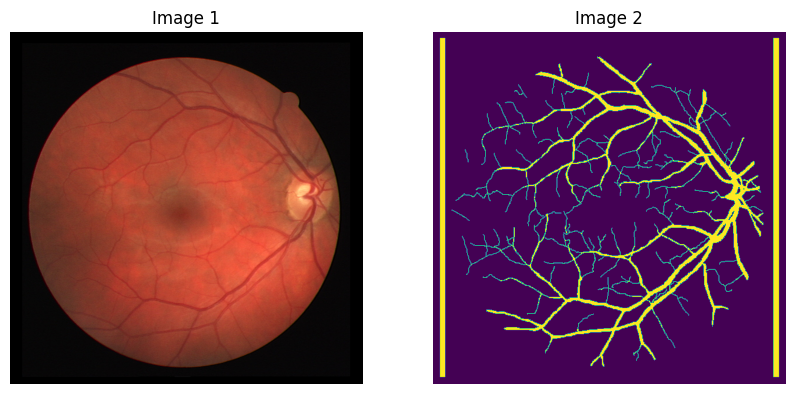

In [17]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

image1 =x_train[9]
image2 = y_train[9]
# Plot the first image
axes[0].imshow(image1)
axes[0].set_title('Image 1')
axes[0].axis('off')

# Plot the second image
axes[1].imshow(image2)
axes[1].set_title('Image 2')
axes[1].axis('off')

plt.show()

#Loss Functions

In [18]:
import tensorflow.keras.backend as K
def topk_loss(y_true, y_pred):
  k=0.1
  # Calculate the number of pixels to consider
  num_pixels = tf.cast(tf.reduce_prod(tf.shape(y_true)[1:]), tf.float32)
  num_pixels_to_consider = tf.cast(k * num_pixels, tf.int32)
  # Calculate the loss only for the top k% hardest pixels to classify
  loss = -tf.reduce_sum(tf.nn.top_k(tf.reshape(y_true * y_pred, [-1]), num_pixels_to_consider).values)
  return loss

# Example usage:
# Assuming y_true and y_pred are your ground truth and predicted segmentation masks respectively
# k = 0.1 (considering top 10% of pixels)
# loss = topk_loss(y_true, y_pred, k)
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def jaccard_index(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + K.epsilon()) / (union + K.epsilon())

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (total_positives + K.epsilon())

def hausdorff_distance(y_true, y_pred):
    surface_distances = tf.reduce_sum(y_true * y_pred, axis=[1, 2]) / tf.reduce_sum(y_true + y_pred, axis=[1, 2])
    hausdorff_distance = tf.reduce_max(surface_distances)
    return hausdorff_distance

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    total_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (total_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    total_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (total_positives + K.epsilon())

def hybrid_loss(y_true, y_pred):
    """
    Hybrid loss function combining squared error (SE) and cross-entropy (CE) loss functions.

    """
    s1=0.3
    s2=0.7
    epsilon=1e-6
    # Squared Error (SE) loss
    se_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    # Cross-Entropy (CE) loss
    ce_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))

    # Normalize the error values
    max_se = tf.reduce_max(se_loss)
    max_ce = tf.reduce_max(ce_loss)
    max_se = tf.maximum(max_se, epsilon)
    max_ce = tf.maximum(max_ce, epsilon)

    # Hybridized loss function
    hybrid_loss = s1 * (se_loss / max_se) + s2 * (ce_loss / max_ce)

    return hybrid_loss


beta = 0.25
alpha = 0.25
gamma = 2
epsilon = 1e-5
smooth = 1

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


def logcsh_loss(y_true, y_pred):
    loss = tf.math.log(tf.math.cosh(y_pred - y_true))
    return tf.reduce_mean(loss)

def hybrid(y_true, y_pred):
  s1=0.3
  s2=0.7
  return s1*(dice_coef_loss(y_true, y_pred)) + s2*(logcsh_loss(y_true, y_pred))

#Model Architecture  

In [19]:
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 608, 608, 3

In [20]:
import tensorflow as tf,math
from tensorflow.keras import layers, models

def ghost_module(input_tensor, num_filters, ratio=2):
    # Primary convolution
    init_channels = math.ceil(num_filters / ratio)
    primary_conv = layers.Conv2D(init_channels, (3, 3), padding='same')(input_tensor)

    # Cheap operations
    cheap_ops = layers.DepthwiseConv2D((3, 3), padding='same')(primary_conv)
    for _ in range(ratio - 1):
        cheap_ops = layers.DepthwiseConv2D((3, 3), padding='same')(cheap_ops)

    # Concatenate outputs
    output_tensor = layers.concatenate([primary_conv, cheap_ops], axis=-1)
    return output_tensor


In [25]:
#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) ##Used for normailizing the pixal values

#Contraction path
c1 = ghost_module(s, 64, ratio=2)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = ghost_module(c1, 64, ratio=2)
p1 = tf.keras.layers.MaxPooling2D((2, 2), name="Level_1")(c1)

c2 = ghost_module(p1, 64, ratio=2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = ghost_module(c2, 64, ratio=2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = ghost_module(c2, 64, ratio=2)
p2 = tf.keras.layers.MaxPooling2D((2, 2), name="Level_2")(c2)

c3 = ghost_module(p2, 64, ratio=2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = ghost_module(c3, 64, ratio=2)
c3 = tf.keras.layers.Dropout(0.1)(c3)
c3 = ghost_module(c3, 64, ratio=2)
p3 = tf.keras.layers.MaxPooling2D((2, 2), name="Level_3")(c3)

c4 = ghost_module(p3, 64, ratio=2)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = ghost_module(c4, 64, ratio=2)
c4 = tf.keras.layers.Dropout(0.1)(c4)
c4 = ghost_module(c4, 64, ratio=2)
p4 = tf.keras.layers.MaxPooling2D((2, 2), name="Level_4")(c4)


c5 = ghost_module(p4, 64, ratio=2)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = ghost_module(c5, 64, ratio=2)
c5 = tf.keras.layers.Dropout(0.1)(c5)
c5 = ghost_module(c5, 64, ratio=2)

#Up Sampling Process
#Expansive path   Decovloution :output_dim = (img - 1) * strides + kernel_size + 2 * padding
#It performs a deconvolution or upconvolution operation, essentially the opposite of a standard convolution.
#padding = same ===> padding = (filter - 1) // 2
"""
Padding == ‘Same’:
Output Height (H) = Input Height (H1) × Stride
Output Width (W) = Input Width (W1) × Stride
Padding == ‘Valid’:
Output Height (H) = (Input Height (H1) - 1) × Stride + Kernel Height (HF) - 2 × p
Output Width (W) = (Input Width (W1) - 1) × Stride + Kernel Width (WF) - 2 × p
"""

u5 = tf.keras.layers.UpSampling2D(size=(16, 16),name="U5")(c5)
u4 = tf.keras.layers.UpSampling2D(size=(8, 8) ,name ="U4")(c4)
u3 = tf.keras.layers.UpSampling2D(size=(4, 4) ,name ="U3")(c3)
u2 = tf.keras.layers.UpSampling2D(size=(2, 2), name="U2")(c2)

add = tf.keras.layers.Add()([u2,u3,u4,u5,c1])
#add = tf.expand_dims(add, axis=0)  # Add a batch dimension

c6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name = "C6")(add)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',name = "C7")(c6)




outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', name="output_layer")(c7)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(1e-2), loss='binary_crossentropy', metrics=[dice_coef_loss,jaccard_index,precision,specificity,hausdorff_distance,recall,sensitivity,'accuracy'])

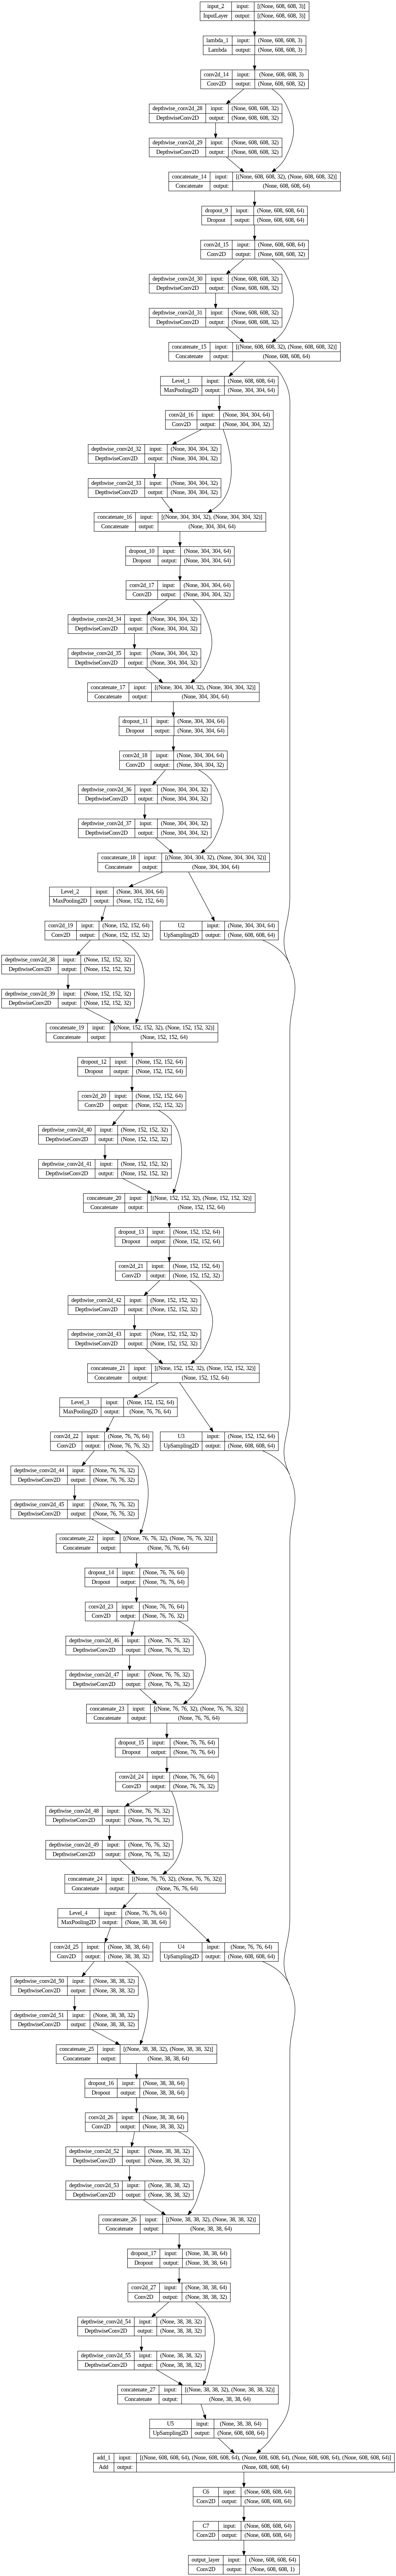

In [26]:
plot_model(model, to_file='model_architecture.png', show_shapes=True)

#Call Backs

In [27]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

# Define your callbacks
filepath = 'saved_models/weights-improvement-{epoch:02d}-{val_accuracy:.4f}.hdf5'  # Placeholder for validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')  # Save the model with the highest validation accuracy
#early_stop = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1, mode='max')  # Early stopping based on validation accuracy
log_csv = CSVLogger('my_logs.csv', separator=',', append=False)  # Logging to CSV file



In [28]:
# Assuming model is defined elsewhere
results = model.fit(x_train, y_train, validation_data=(x_test,y_test),
                    batch_size=4, epochs=20,callbacks=[log_csv,checkpoint]
                    )


Epoch 1/20
8/8 [==============================] - ETA: 0s - loss: 459.8540 - dice_coef_loss: 0.9199 - jaccard_index: 0.0437 - precision: 0.0340 - specificity: 0.9562 - hausdorff_distance: 0.0441 - recall: 0.0576 - sensitivity: 0.0576 - accuracy: 0.8594
Epoch 1: val_accuracy improved from -inf to 0.89416, saving model to saved_models/weights-improvement-01-0.8942.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 34s 974ms/step - loss: 459.8540 - dice_coef_loss: 0.9199 - jaccard_index: 0.0437 - precision: 0.0340 - specificity: 0.9562 - hausdorff_distance: 0.0441 - recall: 0.0576 - sensitivity: 0.0576 - accuracy: 0.8594 - val_loss: 0.6849 - val_dice_coef_loss: 0.8256 - val_jaccard_index: 0.0955 - val_precision: 0.0000e+00 - val_specificity: 1.0000 - val_hausdorff_distance: 0.0954 - val_recall: 0.0000e+00 - val_sensitivity: 0.0000e+00 - val_accuracy: 0.8942
Epoch 2/20
8/8 [==============================] - ETA: 0s - loss: 1.9035 - dice_coef_loss: 0.8231 - jaccard_index: 0.0970 - precision: 0.0059 - specificity: 0.9996 - hausdorff_distance: 0.0952 - recall: 8.4440e-05 - sensitivity: 8.4440e-05 - accuracy: 0.8916
Epoch 2: val_accuracy did not improve from 0.89416
8/8 [==============================] - 6s 766ms/step - loss: 1.9035 - dice_coef_loss: 0.8231 - jaccard_index: 0.0970 - precision: 0.0059 - specificity: 0.9996 - hausdorff_distance: 0.0952 - recall: 8.

#plotting losses

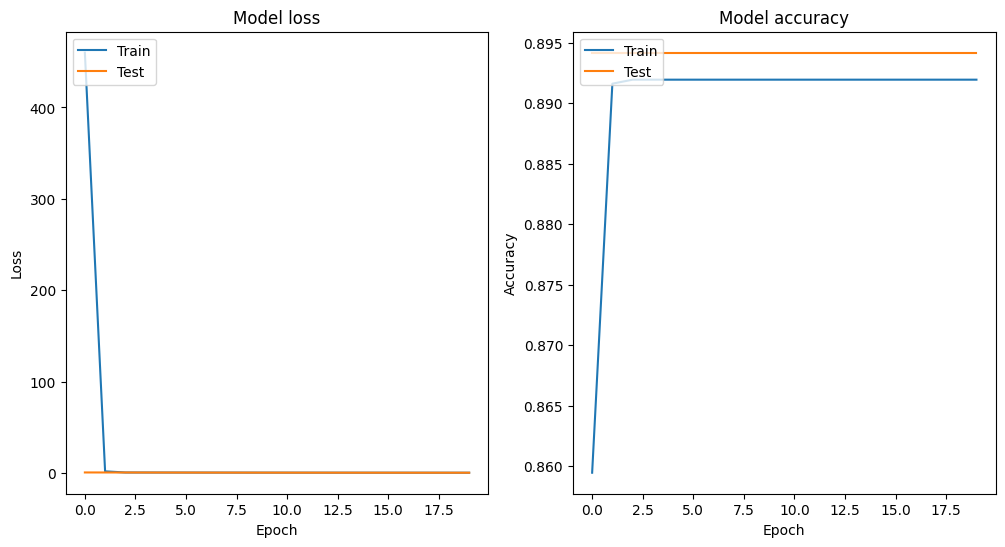

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()
